In [381]:
# import the necessary packages
import os
import cv2
import time
import logging
import numpy as np
import pandas as pd
from math import atan2, pi, sqrt
from matplotlib import pyplot as plt

In [116]:
# start logging

logging.basicConfig()
logger = logging.getLogger()
logger.setLevel(level=logging.INFO)

In [168]:
%matplotlib inline

____

In [176]:
# Create decorator for timing functions

def timeit(method):
    def timed(*args, **kw):
        ts = time.time()
        result = method(*args, **kw)
        te = time.time()
        if 'log_time' in kw:
            name = kw.get('log_name', method.__name__.upper())
            kw['log_time'][name] = int((te - ts))
        else:
            print('{0}  {1:2.2f} s'
                  .format(method.__name__, (te - ts)))
        return result
    return timed

In [165]:
# Apply hough transform

@timeit
def apply_hough_transform(img, min_rad=500, max_rad=None):
    """
    Get the top resulting cricle from the hough circle transform
    """
    # Get max rad
    if max_rad is None:
        max_rad = img.shape[0] // 2
    # Convert to gray-scale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Blur the image to reduce noise
    img_blur = cv2.medianBlur(gray, 5)
    # Get the circles
    circles =\
        cv2.HoughCircles(img_blur, cv2.HOUGH_GRADIENT, 1,
                         img.shape[0], param1=200, param2=10,
                         minRadius=500, maxRadius=img.shape[0]//2)
    # Return the top circle
    top_circle = circles[0][0]
    return top_circle

In [177]:
# Crop image and strip background that is not circle

@timeit
def circle_crop(img, circle, buffer=0.1):
    """
    Take input image and tuple that defines (x, y, r) of circle.
    Buffer extends radius around center of circle and removes all outside of that zone.
    """
    x, y, r = circle
    # crop image
    buffer = max([buffer, 0]) + 1
    y_top = int(y - r * buffer)
    y_bottom = int(y + r * buffer)
    x_left = int(x - r * buffer)
    x_right = int(x + r * buffer)
    img_out = img[y_top:y_bottom, x_left:x_right].copy()
    # adjust circle coordinates
    new_xy = int(0 + r * buffer) + 0.5
    circle = np.array([new_xy, new_xy, r])
    return img_out, circle

In [166]:
# Crop image and strip background that is not circle

@timeit
def circle_strip(img, circle, buffer=.1,
                 background=(255, 255, 255), alpha=0):
    """
    Take input image and tuple that defines (x, y, r) of circle.
    If crop, remove all pixels outside of circle with alpha value.
    Buffer defines square around center that will not be cropped.
    If not crop, set all pixels outside of the cirlce to background.
    """
    x, y, r = circle
    img_out = []
    if img.shape[2] == 3:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGBA)
    for iy, _ in enumerate(img):
        img_x = []
        for ix, _ in enumerate(img[iy]):
            pix = img[iy][ix]
            if (ix - x) ** 2 + (iy - y) ** 2 > r ** 2:
                if background is not None:
                    pix = list(background)
                    pix.append(255)
                if alpha is not None:
                    pix[3] = alpha
            img_x.append(pix)
        img_out.append(img_x)
    img_out = np.array(img_out)
    img_out = np.uint16(np.around(img_out))
    return img_out

In [167]:
# Draw detected circles

@timeit
def draw_circle(img, circle, center=True):
    """
    Take image and circle, draw green outer perimeter,
    put red dot in center
    """
    img_out = img.copy()
    circle = np.uint16(np.around(circle))
    if img.shape[2] == 3:
        outer_color = (0, 255, 0)
        innner_color = (255, 0, 0)
    elif img.shape[2] == 4:
        outer_color = (0, 255, 0, 255)
        innner_color = (255, 0, 0, 255)
    else:
        return img
    # Draw outer circle
    cv2.circle(img_out, (circle[0], circle[1]),
               circle[2], outer_color, img.shape[0] // 100)
    if center:
        # Draw inner circle
        cv2.circle(img_out, (circle[0], circle[1]),
                   4, innner_color, img.shape[0] // 50)
    return img_out

In [273]:
# Get objects to help with band counts

@timeit
def band_wrap(img, circle, scale=(0.9, 0.95)):
    """
    Take input image and tuple that defines (x, y, r) of circle.
    Scale set to portion of radius analyzed for band sequence.
    Reutrns image of average pixel colors as well as series
    set to total distance away from black.
    """
    x, y, r = circle
    rad_dict = dict()
    for iy, _ in enumerate(img):
        for ix, _ in enumerate(img[iy]):
            if (ix - x) ** 2 + (iy - y) ** 2 > (r * scale[1]) ** 2:
                continue
            if (ix - x) ** 2 + (iy - y) ** 2 < (r * scale[0]) ** 2:
                continue
            # add val to dict
            pix = img[iy][ix]
            rad = round(atan2(y - iy, ix - x), 2)
            if rad not in rad_dict:
                rad_dict[rad] = []
            rad_dict[rad].append(pix)
    # set dictionary averages
    rad_dict = \
        {k:np.mean(v, axis=0) for k,v in rad_dict.items()}
    # create ordered array 1/pi as wide as long
    keys = sorted(list(rad_dict.keys()))
    # create series
    sqr = lambda e: e ** 2
    cro = lambda e: sqrt(sum(map(sqr, e[:3])))
    cser =\
        pd.Series([cro(rad_dict[k]) for k in keys], index=keys)
    # build img_out
    width = int(len(keys) / (pi * 2))
    img_out = []
    for k in keys:
        l = list(rad_dict[k])
        l = [l for i in range(width)]
        img_out.append(l)
    img_out = np.array(img_out)
    img_out = np.uint16(np.around(img_out))
    return img_out, cser

In [358]:
# COUNT BANDS

@timeit
def count_bands(cser, tresh=100, min_rad=10):
    mr = round(min_rad / 100, 2)
    ts = cser[((cser > 100).astype(int).diff() == 1)]
    ct = 0
    if ts.shape[0] == 0:
        return ct
    it = ts.index[0] - mr
    for i in ts.index:
        dif = round(i - it, 2)
        if dif >= mr:
            ct += 1
        it = i
    return ct

____

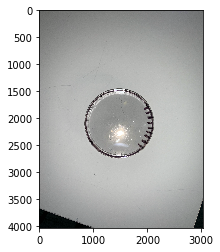

In [373]:
# LOAD DATA
img_file = './data/marpo_circle_0.jpg'
img_raw = cv2.imread(img_file, cv2.IMREAD_COLOR)
plt.imshow(img_raw)

In [173]:
# RUN PREP FUNCTION

@timeit
def prep_image(img_raw):    
    circle = apply_hough_transform(img_raw)
    img, circle = circle_crop(img, circle)
    img = circle_strip(img, circle)
    return img, circle

img, circle = prep_image(img_raw)

draw_circle  25.33 ms


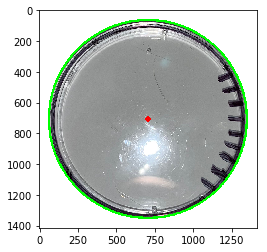

In [369]:
# DISPLAY RENDERED OUTPUT

img_circle = draw_circle(img, circle)
plt.imshow(img_circle)

In [368]:
# GET BAND PIC AND CSER

band_pic, cser = band_wrap(img, circle)
band_ct = count_bands(cser)

band_wrap  4.86 s
count_bands  0.00 s


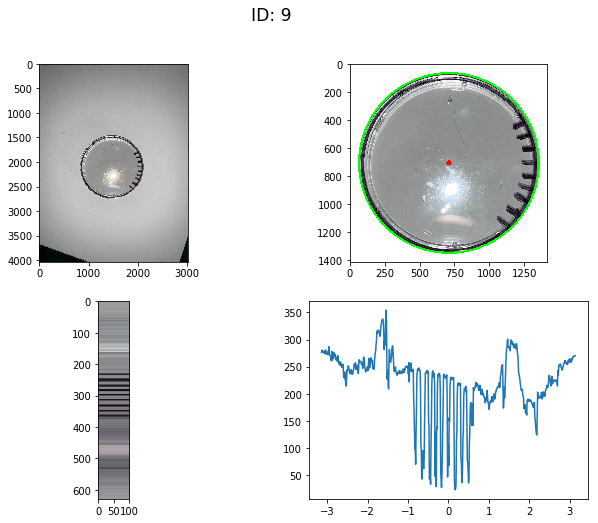

In [383]:
# OUTPUT IMAGES
fig, ax = plt.subplots(2, 2, figsize=(11, 8))
plt.suptitle('')
ax[0][0].imshow(img_raw)
ax[0][1].imshow(img_circle)
ax[1][0].imshow(band_pic)
cser.plot(ax=ax[1][1])
plt.suptitle(f'ID: {band_ct}', size='xx-large')
plt.show()
out_dir = os.path.join(os.getcwd(), 'out')
if not os.path.exists(out_dir):
    os.mkdir(out_dir)
fig.savefig(os.path.join(out_dir, 'marpo_id.png'))

_____